# 运用逻辑回归实现手写数字0-9的识别（多分类）  

In [44]:
#读取m文件
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [45]:
data=loadmat('ex3data1.mat')

这是一个MATLAB格式的.m文件，其中包含5000个20*20像素的手写字体图像，以及他对应的数字。另外，数字0的y值，对应的是10

In [46]:
#打印看看
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [47]:
data['X'].shape,data['y'].shape

((5000, 400), (5000, 1))

5000个数字，每个数字都是20 x 20 像素的图像，即样本数为5000，特征数为400

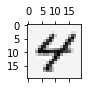

[4]


In [48]:
#随便画出其中一个看看
random_num=np.random.randint(0,5000)
fig,ax=plt.subplots(figsize=(1,1))
#cmap=matplotlib.cm.binary我猜是二值化颜色图
ax.matshow(data['X'][random_num,:].reshape((20,20)).T,cmap=matplotlib.cm.binary)
plt.show()
print(data['y'][random_num])

--- 
### 多分类逻辑回归

sigmoid函数
\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 

In [49]:
#定义sigmoid函数
def sigmoid(z):
    return 1/(1+np.exp(-z))

# regularized cost（正则化代价函数）
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [50]:
#参考代码里面用的代码是带正则化的，所以公式中应带正则化项
def costReg(theta,X,y,learning_rate):
    theta=np.matrix(theta)
    X=np.matrix(X)
    y=np.matrix(y)
    
    first=np.multiply(-y,np.log(sigmoid(X*theta.T)))
    second=np.multiply((1-y),np.log(1-sigmoid(X*theta.T)))
    reg=learning_rate/(2*len(X))*np.sum(np.power(theta[:,1:theta.shape[1]],2))
    
    return np.sum(first-second)/(len(X))+reg

使用梯度下降法令这个代价函数最小化，因为我们未对${{\theta }_{0}}$ 进行正则化，所以梯度下降算法将分两种情形：
\begin{align}
  & Repeat\text{ }until\text{ }convergence\text{ }\!\!\{\!\!\text{ } \\ 
 & \text{     }{{\theta }_{0}}:={{\theta }_{0}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}} \\ 
 & \text{     }{{\theta }_{j}}:={{\theta }_{j}}-a[\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}+\frac{\lambda }{m}{{\theta }_{j}}] \\ 
 & \text{          }\!\!\}\!\!\text{ } \\ 
 & Repeat \\ 
\end{align}

对上面的算法中 j=1,2,...,n 时的更新式子进行调整可得： 
${{\theta }_{j}}:={{\theta }_{j}}(1-a\frac{\lambda }{m})-a\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{j}^{(i)}}$

In [51]:
#优化ex2中的梯度下降函数，将for循环改成向量运算以加速计算
#https://www.heywhale.com/mw/project/5da56d46c83fb4004202c42b有矩阵部分的一些推导
def gradient(theta,X,y,learning_rate):
    theta=np.matrix(theta)
    X=np.matrix(X)
    y=np.matrix(y)
    
    error=sigmoid(X*theta.T)-y#X是m x (n+1)维,theta是1 x (n+1)维,所以结果是m x 1维度
    #根据网页公式的推导可以得出X.T*error的结论
    grad1=X.T*error/len(X)#(n+1) x 1维度
    grad=grad1.T+learning_rate/len(X)*theta#转置下grad1使其变为1 x (n+1)维
    
    #因为theta0不需要正则化，所以根据公式单独覆盖掉theta0
    grad[0,0]=np.sum(np.multiply(error,X[:,0]))/len(X)
    
    return np.array(grad).ravel()#应该还是1 x (n+1)维

现在我们已经定义了代价函数和梯度函数，现在是构建分类器的时候了。 对于这个任务，我们有10个可能的类，并且由于逻辑回归只能一次在2个类之间进行分类，我们需要多类分类的策略。 在本练习中，我们的任务是实现一对一全分类方法，其中具有k个不同类的标签就有k个分类器，每个分类器在“类别 i”和“不是 i”之间决定。 我们将把分类器训练包含在一个函数中，该函数计算10个分类器中的每个分类器的最终权重，并将权重返回为k X（n + 1）数组，其中n是参数数量。

In [52]:
from scipy.optimize import minimize

In [53]:
def one_vs_all(X,y,num_labels,learning_rate):
    rows=X.shape[0]
    columns=X.shape[1]#也就是参数的数目
    
    #构造k个分类器的拟合参数矩阵
    all_theta=np.zeros((num_labels,columns+1))
    #插入对象；插入位置；插入的值；axis=1表示增加的向量以列的形式
    X=np.insert(X,0,values=np.ones(rows),axis=1)
    
    #参考代码中的标签从1开始(因为0用标签10表示了)
    for i in range(1,num_labels+1):
        theta=np.zeros(columns+1)
        y_i=[]#列表初始化
        #每个分类器转换为二分类问题
        for label in y:
            if label==i:
                y_i.append(1)
            else:
                y_i.append(0)
        y_i=np.array(y_i)#列表转换成np的array格式 1 x rows 维度
        y_i=np.reshape(y_i,(rows,1))#转换成 rows x 1维度
        #求最小化代价函数对应的参数
        #fun：该参数就是costFunction，要去最小化的损失函数，损失函数在定义时，theta必须为第一个参数且其shape必须为(n,)即一维数组
        #x0：初始化的theta,其shape必须为shape(n,)即一维数组
        #args：其他参数，如X，Y，lambda等
        #method：该参数代表采用的方式，默认是BFGS, L-BFGS-B, SLSQP中的一种，可选TNC
        #jac：该参数就是计算梯度的函数，和fun参数类似，第一个必须为theta且其shape必须为(n,)即一维数组,最后返回的梯度也必须为一个一维数组。
        fmin=minimize(fun=costReg,x0=theta,args=(X,y_i,learning_rate),method='tnc',jac=gradient)
        all_theta[i-1,:]=fmin.x#保存当前分类器的参数到all_theta的对应行
    
    return all_theta

10个分类器，第一个分类器负责预测是标签1的概率，以此类推。

In [54]:
rows=data['X'].shape[0]
columns=data['X'].shape[1]

all_theta=np.zeros((10,columns+1))#+1是为了添加一个额外的参数theta0
#插入对象；插入位置；插入的值；axis=1表示增加的向量以列的形式
X=np.insert(data['X'],0,np.ones(rows),axis=1)

#对参数进行初始化以及检查维度
theta=np.zeros(columns+1)

y_1=[]
for label in data['y']:
    if label==1:#参考代码用的label==0，但是标签里面应该是没有0的，其实也不影响
        y_1.append(1)
    else:
        y_1.append(0)
y_1=np.array(y_1)
y_1=np.reshape(y_1,(rows,1))
            
X.shape,y_1.shape,theta.shape,all_theta.shape

((5000, 401), (5000, 1), (401,), (10, 401))

In [55]:
#检查标签
#对于一维数组或者列表，unique函数去除其中重复的元素，并按元素由小到大返回一个新的无重复元素的数组或者列表
np.unique(data['y'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [57]:
all_theta=one_vs_all(data['X'],data['y'],10,1)
all_theta,all_theta.shape

(array([[-2.38291346e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.30474743e-03, -8.24531507e-10,  0.00000000e+00],
        [-3.18403111e+00,  0.00000000e+00,  0.00000000e+00, ...,
          4.46025411e-03, -5.08531235e-04,  0.00000000e+00],
        [-4.80012163e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -2.88116417e-05, -2.47992614e-07,  0.00000000e+00],
        ...,
        [-7.98722644e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -8.95295280e-05,  7.21832616e-06,  0.00000000e+00],
        [-4.57235036e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.33349450e-03,  9.96261157e-05,  0.00000000e+00],
        [-5.40509120e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.16616386e-04,  7.88424336e-06,  0.00000000e+00]]),
 (10, 401))

In [58]:
#用训练完毕的分类器预测每个图像的标签，输入样本，输出标签
def predict_all(X,all_theta):
    rows=X.shape[0]
    columns=X.shape[1]
    num_labels=all_theta.shape[0]#即10个类别
    
    #同样我们要向X插入一列1
    X=np.insert(data['X'],0,np.ones(rows),axis=1)#5000 x 401
    
    #矩阵化
    X=np.matrix(X)
    all_theta=np.matrix(all_theta)
    
    #计算每个类的类别概率
    h=sigmoid(X*all_theta.T)
    h_argmax=np.argmax(h,axis=1)#关于这个axis=1参考下面的解释
    #把索引变成从1开始，因为标签0对应索引10
    h_argmax=h_argmax+1
    
    return h_argmax

之前在代码：```X=np.insert(X,0,values=np.ones(rows),axis=1)```当中，曾认为axis=1表示列插入，这里应当纠正下解释，针对二维数组来说确实可以理解成axis=0表示行插入，axis=1表示列插入，但是如果这么理解，上面代码中的```h_argmax=np.argmax(h,axis=1)```中的axis可能会误解成统计每列的最大值。因为我们都知道本练习当中h的结果应该为5000 x 10 维度，每行表示当前数字对应在10个分类器下的预测概率结果，我们应当取每行的最大预测概率而非每列的最大预测概率。    
其实只要理解了numpy中的参数axis所表示的含义，就明白为什么取0 1或者其他参数了，简单来说就是**最外面的括号代表着 axis=0，依次往里的括号对应的 axis 的计数就依次加 1**  
详细可以参考这篇：  
https://zhuanlan.zhihu.com/p/30960190

In [59]:
y_predict=predict_all(data['X'],all_theta)

#统计正确率
correct=0
for i in range(len(y_predict)):
    if y_predict[i]==data['y'][i]:
        correct=correct+1

accuracy=correct/(len(y_predict))
print('accuracy = {0}%'.format(accuracy*100))

accuracy = 94.46%
